In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import pandas as pd

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.4.1


In [3]:
with open('../input/smart-reply-sentence-similarity-using-annoy/input_texts.pickle', 'rb') as handle:
    input_texts = pickle.load(handle)
    
with open('../input/smart-reply-sentence-similarity-using-annoy/target_texts.pickle', 'rb') as handle:
    output_texts = pickle.load(handle)
    
with open('../input/smart-reply-clustering-annoy-output/target_dbscan_006.pickle', 'rb') as handle:
    dbscan = pickle.load(handle)

In [4]:
print(len(input_texts))
print(len(dbscan.labels_))

21861
21861


In [5]:
dbscan.labels_.shape

(21861,)

In [6]:
# fitting tokenizer on all short messages
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(input_texts)
total_words = len(tokenizer.word_index) + 1

In [7]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
input_tokens = tokenizer.texts_to_sequences(input_texts)
# input_tokens[:10]

In [9]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors = input_sequences
    #label = tf.keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, max_sequence_len

predictors, max_sequence_len = generate_padded_sequences(input_tokens)

In [10]:
labels = np.array(dbscan.labels_, copy=True)
labels[labels == -1] = len(set(dbscan.labels_)) - 1
print(labels[:10])

[881 881 881   0 881 881 881 881 881 881]


In [11]:
encoder_labels = OneHotEncoder().fit(labels.reshape(-1, 1))
one_hot_labels = encoder_labels.transform(labels.reshape(-1, 1))
one_hot_labels.shape

(21861, 882)

In [12]:
with open('encoder_labels.pickle', 'wb') as handle:
    pickle.dump(encoder_labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = tf.keras.Sequential()
    
    # Add Input Embedding Layer
    model.add(tf.keras.layers.Embedding(total_words, 512, input_length=input_len))
    
    # Add Hidden Layer 1 - LSTM Layer
    #model.add(tf.keras.layers.LSTM(256, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.LSTM(512))
    model.add(tf.keras.layers.Dropout(0.2))
    
    # Add Output Layer
    model.add(tf.keras.layers.Dense(one_hot_labels.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
    
    return model


with strategy.scope():
    model = create_model(max_sequence_len, total_words)
    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 512)           7095296   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 882)               452466    
Total params: 9,646,962
Trainable params: 9,646,962
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(predictors, one_hot_labels.todense(), epochs=25, verbose=1)

Epoch 1/25
684/684 [==============================] - 24s 25ms/step - loss: 1.9564 - accuracy: 0.7761
Epoch 2/25
684/684 [==============================] - 14s 21ms/step - loss: 1.5578 - accuracy: 0.7899
Epoch 3/25
684/684 [==============================] - 14s 21ms/step - loss: 1.4903 - accuracy: 0.7862
Epoch 4/25
684/684 [==============================] - 14s 21ms/step - loss: 1.3270 - accuracy: 0.7950
Epoch 5/25
684/684 [==============================] - 14s 21ms/step - loss: 1.1643 - accuracy: 0.8064
Epoch 6/25
684/684 [==============================] - 14s 21ms/step - loss: 1.0256 - accuracy: 0.8090
Epoch 7/25
684/684 [==============================] - 14s 21ms/step - loss: 0.8463 - accuracy: 0.8236
Epoch 8/25
684/684 [==============================] - 14s 21ms/step - loss: 0.6656 - accuracy: 0.8502
Epoch 9/25
684/684 [==============================] - 14s 21ms/step - loss: 0.4974 - accuracy: 0.8803
Epoch 10/25
684/684 [==============================] - 14s 21ms/step - loss: 0.339

In [15]:
# Save model
model.save("op_annoy_lstm.hdf5")

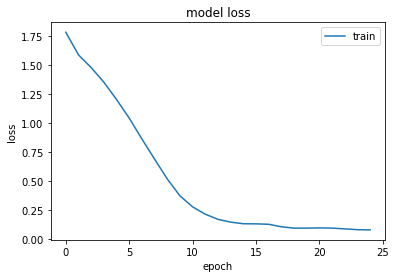

In [16]:
import matplotlib.pyplot as plt
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [17]:
predictions = model.predict_classes(predictors, verbose=0)
predictions

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([881, 881, 881, ..., 881, 881, 881])

In [18]:
unique, counts = np.unique(predictions, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0  1088]
 [    1    46]
 [    2     3]
 ...
 [  879     2]
 [  880     2]
 [  881 17183]]


In [19]:
np.where(predictions==1)

(array([   34,   833,  1013,  2391,  2684,  2728,  2734,  4158,  4252,
         4530,  5233,  5454,  6335,  6642,  7208,  7327,  7451,  7894,
         7979,  8485,  8752,  9680,  9688,  9798, 10936, 11012, 11740,
        12101, 12468, 12844, 13033, 13399, 14305, 14310, 14313, 14490,
        14805, 15027, 15832, 15847, 16679, 16785, 17698, 20110, 20740,
        21223]),)

In [20]:
labels

array([881, 881, 881, ..., 881, 881, 881])

In [21]:
def get_responses(seed_text, n):
    print("Input -", seed_text)
    print("----------------------")
    responses = list()
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    with strategy.scope():
        predictions = model.predict(token_list, verbose=10)
        # print(model.predict_classes(token_list, verbose=10))
        # print(predictions)
        predicted_indices = predictions.argsort()[0][::-1][:n]
        print(predicted_indices)
        #print(encoder_labels.inverse_transform([[533]]))
    
    for predicted_index in predicted_indices:
        score = 0
        if predicted_index == len(set(dbscan.labels_)) - 1:
            print("Predicting outside clusters")
            predicted_index = -1
        else:
            score = predictions[0][predicted_index]
            
        # randomly pick 1 index
        possible_response = np.where(dbscan.labels_==predicted_index)[0]
        response_index = random.sample(possible_response.tolist(), 1)[0]
        # print(response_index)
        responses.append([output_texts[response_index].replace("\t", "").replace("\n", ""), score])


    for i, response in enumerate(responses):
        print("Response", (i + 1), "->", response[0], " -> Score :", response[1])

In [22]:
get_responses("goodbye", 5)

Input - goodbye
----------------------
[  0 307 881  16  93]
Predicting outside clusters
Response 1 -> ta.  -> Score : 0.80264837
Response 2 -> i don't understand  -> Score : 0.1614099
Response 3 -> yeah he got caught stealing.  -> Score : 0
Response 4 -> thanks you too.  -> Score : 0.0058214646
Response 5 -> same to you.  -> Score : 0.004095591


In [23]:
get_responses(input_texts[9], 5)

Input - he was indeed his music is even in the library of congress.
----------------------
[881 320 818 338 156]
Predicting outside clusters
Response 1 -> i like dc but grew up watching bmore.  -> Score : 0
Response 2 -> yes it is there for cultural significance  -> Score : 0.004024648
Response 3 -> yes it's true.  -> Score : 0.00024570542
Response 4 -> what is the candy desk  -> Score : 7.233429e-05
Response 5 -> well i got to go nice talking with you  -> Score : 6.6268054e-05


In [24]:
get_responses(input_texts[508], 5)

Input - so cool. nice chatting with you
----------------------
[ 70 881   1 585   0]
Predicting outside clusters
Response 1 -> same here  -> Score : 0.93253255
Response 2 -> hi how are you i sometimes watch baseball. you  -> Score : 0
Response 3 -> you as well.  -> Score : 0.016216712
Response 4 -> yes same here  -> Score : 0.0031270455
Response 5 -> bye.  -> Score : 0.0020802054


In [25]:
get_responses(input_texts[21223], 5)

Input - thanks. have a great day.
----------------------
[  1   0 881  16 170]
Predicting outside clusters
Response 1 -> you as well  -> Score : 0.73519754
Response 2 -> literature  -> Score : 0.17584628
Response 3 -> maybe it got passed down to his children.  -> Score : 0
Response 4 -> thanks. you too.  -> Score : 0.011126764
Response 5 -> the same to you.  -> Score : 0.005872339


In [26]:
get_responses("have a great day.", 5)

Input - have a great day.
----------------------
[  0 881   1  93 170]
Predicting outside clusters
Response 1 -> i like trump  -> Score : 0.5556589
Response 2 -> mine too. do you like animals  -> Score : 0
Response 3 -> you as well  -> Score : 0.09248673
Response 4 -> same to you.  -> Score : 0.07962441
Response 5 -> the same to you.  -> Score : 0.046950508


In [27]:
get_responses("do you like dance", 5)

Input - do you like dance
----------------------
[881  96 164  50 431]
Predicting outside clusters
Response 1 -> i think the ceo has colorblindness.  -> Score : 0
Response 2 -> hello no i do not do you  -> Score : 0.00736947
Response 3 -> i do like sports. do you  -> Score : 0.0045045656
Response 4 -> yes i do do you  -> Score : 0.0042443383
Response 5 -> i sure do what about you  -> Score : 0.0032472466


In [28]:
get_responses("good morning", 5)

Input - good morning
----------------------
[  0 881 107  16  42]
Predicting outside clusters
Response 1 -> disney  -> Score : 0.8870121
Response 2 -> you mean the line supported by nike and jordan  -> Score : 0
Response 3 -> thanks you as well.  -> Score : 0.010050118
Response 4 -> thanks you too.  -> Score : 0.0011219211
Response 5 -> good bye  -> Score : 0.0005267606


In [29]:
get_responses("how are you", 5)

Input - how are you
----------------------
[881 125 452 855 313]
Predicting outside clusters
Response 1 -> i wonder how apple would even check that.  -> Score : 0
Response 2 -> great. how are you  -> Score : 0.005419015
Response 3 -> i'm good. how are you  -> Score : 0.0047490904
Response 4 -> i am doing well. how are you  -> Score : 0.0042373533
Response 5 -> good. how are you  -> Score : 0.0029580065
